In [1]:
# data format: city, state usps code, list of counties
cities = [
    ('New York City', 'ny', ['New York County, NY', 'Queens County, NY','Kings County, NY','Bronx County, NY','Richmond County, NY']),
    ('Los Angeles', 'ca', ['Los Angeles County, CA']),
    ('Chicago', 'il', ['Cook County, IL']),
    ('Houston', 'tx', ['Harris County, TX']),
    ('Boston', 'ma', ['Suffolk County, MA', 'Middlesex County, MA']),
    ('Phoenix', 'az', ['Maricopa County, AZ']),
    ('Philadelphia', 'pa', ['Philadelphia County, PA']),
    ('San Antonio', 'tx', ['Bexar County, TX']),
    ('San Diego', 'ca', ['San Diego County, CA']),
    ('Dallas', 'tx', ['Dallas County, TX']),
    ('San Jose', 'ca', ['Santa Clara County, CA']),
    ('Austin', 'tx', ['Travis County, TX']),
    #('Jacksonville', 'fl', ['Duval County, FL']),
    #('Fort Worth', 'tx', ['Tarrant County, TX']),
]

cities_test = [
    ('Chicago', 'il', ['Cook County, IL']),
]

In [85]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sttn.network import SpatioTemporalNetwork
from sttn.utils import add_distance
from sklearn.metrics import mean_squared_error
from skmob.models import Gravity
import statsmodels.api as sm

def compute_weights(network, job_column):
    comp_aggs={job_column: 'sum'}
    # outgoing=False corresponds to jobs, outgoing=True corresponds to population 
    jobs = network.agg_adjacent_edges(aggs=comp_aggs, outgoing=False).rename(columns={job_column: 'jobs'})
    residence = network.agg_adjacent_edges(aggs=comp_aggs, outgoing=True).rename(columns={job_column: 'residence'})
    edges = network.edges
    
    edges_with_weights = edges.join(residence, on='origin').join(jobs, on='destination')
    return edges_with_weights
    
def fit_gravity_model(edges, job_column):
    copy = edges.copy()
    copy.loc[(copy['jobs'] == 0), 'jobs'] = 1 
    copy.loc[(copy['residence'] == 0), 'residence'] = 1 
    copy.loc[(copy['distance'] == 0), 'distance'] = 1 
    
    X = sm.add_constant(np.log(copy.distance))
    y = np.log(copy[job_column]) - np.log(copy.jobs) - np.log(copy.distance)
    
    model = sm.OLS(y, X).fit()
    
    return model

def extract_model_exponents(network):
    columns = ['SE01', 'SE03']
    with_distance = add_distance(network)
    filtered_network = with_distance.filter_edges((with_distance.edges.SE01 > 0) & (with_distance.edges.SE03 > 0))
                                             
    result = {}
    for column in columns:
        with_weights = compute_weights(filtered_network, column)
        model = fit_gravity_model(with_weights, column)
        conf_interval = model.conf_int(alpha=0.05, cols=None).loc['distance']
        result[column] = model.params[1]
        result[column + '_error'] = model.params[1] - conf_interval[0]
    
    return result

In [84]:
from sttn.data.lehd import OriginDestinationEmploymentDataProvider
provider = OriginDestinationEmploymentDataProvider()

model_weights = {}
for city, state, conties in cities:
    print('Processing {city}'.format(city=city))
    state_network = provider.get_data(state=state, year=2018)
    city_network = state_network.filter_nodes(state_network.nodes.county.isin(conties))
    zip_city_network = city_network.group_nodes('zip')
    city_network = zip_city_network.agg_parallel_edges(column_aggs={'S000': 'sum', 'SE01': 'sum', 'SE02': 'sum', 'SE03': 'sum'})
    exponents = extract_model_exponents(city_network)
    model_weights[city] = exponents

Processing New York City


/Users/user/PycharmProjects/sttn/src/sttn/utils.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroid = network.nodes.centroid


Processing Los Angeles


/Users/user/PycharmProjects/sttn/src/sttn/utils.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroid = network.nodes.centroid


Processing Chicago


/Users/user/PycharmProjects/sttn/src/sttn/utils.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroid = network.nodes.centroid


Processing Houston


/Users/user/PycharmProjects/sttn/src/sttn/utils.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroid = network.nodes.centroid


Processing Boston


/Users/user/PycharmProjects/sttn/src/sttn/utils.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroid = network.nodes.centroid


Processing Phoenix


/Users/user/PycharmProjects/sttn/src/sttn/utils.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroid = network.nodes.centroid


Processing Philadelphia


/Users/user/PycharmProjects/sttn/src/sttn/utils.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroid = network.nodes.centroid


Processing San Antonio


/Users/user/PycharmProjects/sttn/src/sttn/utils.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroid = network.nodes.centroid


Processing San Diego


/Users/user/PycharmProjects/sttn/src/sttn/utils.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroid = network.nodes.centroid


Processing Dallas


/Users/user/PycharmProjects/sttn/src/sttn/utils.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroid = network.nodes.centroid


Processing San Jose


/Users/user/PycharmProjects/sttn/src/sttn/utils.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroid = network.nodes.centroid


Processing Austin


/Users/user/PycharmProjects/sttn/src/sttn/utils.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroid = network.nodes.centroid


In [48]:
state_network = provider.get_data(state='tx', year=2018)
column = 'SE01'
city_network = state_network.filter_nodes(state_network.nodes.county.isin(['Dallas County, TX']))
zip_city_network = city_network.group_nodes('zip')
city_network = zip_city_network.agg_parallel_edges(column_aggs={'S000': 'sum', 'SE01': 'sum', 'SE02': 'sum', 'SE03': 'sum'})
city_network = add_distance(city_network)
filtered_network = city_network.filter_edges((city_network.edges.SE01 > 0) & (city_network.edges.SE03 > 0))
with_weights = compute_weights(filtered_network, 'SE03')

/Users/user/PycharmProjects/sttn/src/sttn/utils.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroid = network.nodes.centroid


In [78]:
#extract_model_exponents(city_network)
#with_weights
model = fit_gravity_model(with_weights, column)
model.conf_int(alpha=0.05, cols=None).loc['distance'][0]
#model.summary()

-1.7742585119235927

In [ ]:
exlploded_fdf = explode_fdf(fdf)
model = fit_gravity_model(exlploded_fdf)

## Power-law, jobs as weight

In [14]:
df = pd.DataFrame(model_weights).transpose().reset_index().rename(columns={'index':'city'})
df

,city,SE01,SE03
0,New York City,-1.878858,-1.773786
1,Los Angeles,-2.050261,-2.020891
2,Chicago,-2.070712,-2.027254
3,Houston,-1.902414,-1.798384
4,Boston,-1.961690,-1.833310
5,Phoenix,-1.911247,-1.815732
6,Philadelphia,-1.744920,-1.541868
7,San Antonio,-1.777723,-1.510868
8,San Diego,-2.108906,-2.058885
9,Dallas,-1.763940,-1.780189


<AxesSubplot:xlabel='city'>

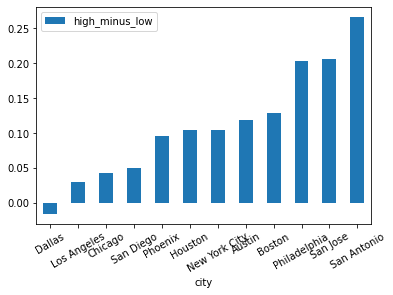

In [15]:
df['high_minus_low'] = df.SE03 - df.SE01
df.sort_values('high_minus_low').plot.bar(x='city', y='high_minus_low', rot=30)

In [110]:
df = pd.DataFrame(model_weights).transpose().rename(columns={'index':'city'})
means = df[['SE01', 'SE03']].copy()
means.SE01 = -means.SE01
means.SE03 = -means.SE03
errors = df[['SE01_error', 'SE03_error']].rename(columns={'SE01_error':'SE01', 'SE03_error':'SE03'})
df

,SE01,SE01_error,SE03,SE03_error
New York City,-1.878858,0.016774,-1.773786,0.015125
Los Angeles,-2.050261,0.010298,-2.020891,0.010102
Chicago,-2.070712,0.017936,-2.027254,0.017436
Houston,-1.902414,0.019744,-1.798384,0.021456
Boston,-1.961690,0.024980,-1.833310,0.024068
Phoenix,-1.911247,0.020201,-1.815732,0.021686
Philadelphia,-1.744920,0.056775,-1.541868,0.046859
San Antonio,-1.777723,0.046895,-1.510868,0.051671
San Diego,-2.108906,0.029142,-2.058885,0.028219
Dallas,-1.763940,0.035479,-1.780189,0.034634


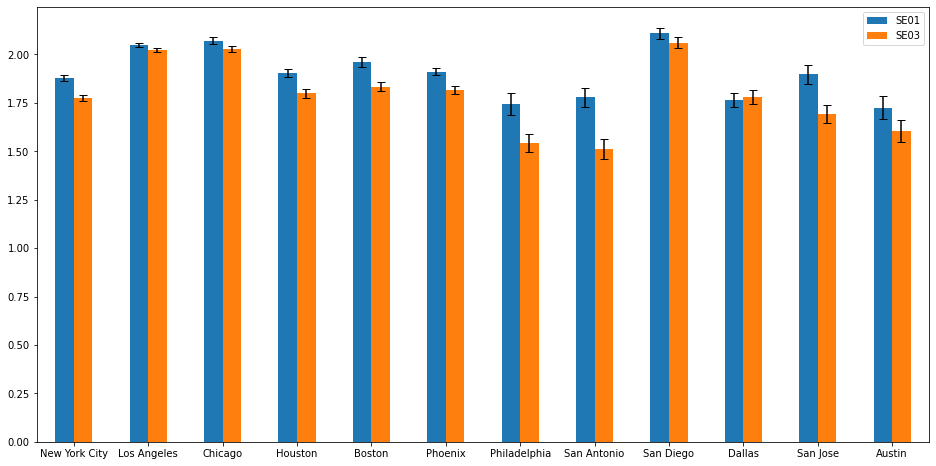

In [109]:
fig, ax = plt.subplots(figsize=(16,8))
means.plot.bar(yerr=errors, ax=ax, capsize=4, rot=0);
plt.show()